## 1. Physical Structure (only aleatory uncertainties in the responses/time series)

The cross-section of the mast is changed from a pipe to a rectangular truss structure to avoid modeling cross-wind vibrations.

The truss structure is based on pictures from Sender Aholming, a guyed truss mast, and parameters are chosen such that mass per meter and second area of moments equal that of the pipe structure, thus previous results can be used.

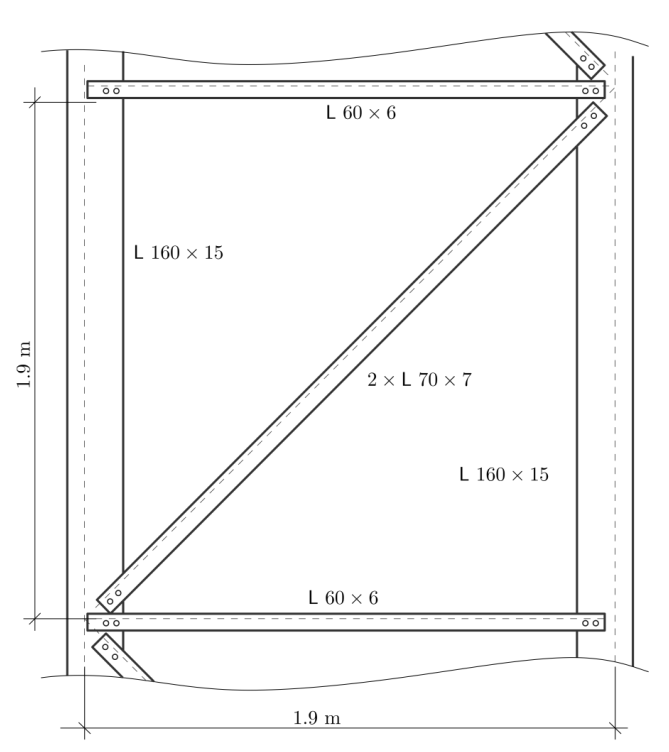

The truss consist of equal leg steel angle profiles. The corners are 160 x 15, the horizontal members are 60 x 6 and the diagonals are two 70 x 7 bolted together on either side of the corner members flange.

The cross-section can be rotated randomly to contain modes of both directions in each sensor signal and also make sure, the equivalent springs do not act in the principal directions of the cross-section.

Wind excitation is based on EN 1991-1-4 with parameters from [Clobes 2008] and the method given by [Solari 2001], [Shinozuka 1972]. Wind direction is fixed to the models coordinate system, as the cross-section can be rotated w.r.t. the wind direction. Basic wind speed $v_b$ (given fixed in EN 1991-1-4) could be considered as random (Weibull, with parameters as estimated from Geyer monitoring data: $c={0.75:[2.267, 2.3],0.25:[1.96, 2.01]}$, $\lambda={0.75:[5.618, 5.649], 0.25:[5.91,6.0]}$, parameters seem to be independent $\rho= {0.03, 0.3}$). 


Other parameters such as integral lengths $L(z)$, correlation lengths $C_{k,j}$ ($k: {u,v,w}, j: {x,y,z}$), spectral bandwidth $f_{s,w}$ might be considered random or fixed.

## Structural Model generation


In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
# dont forget to forward ports: ssh -L 8080:127.0.0.1:8080 sima9999@makalu47.rz.tu-ilmenau.de

import sys
import os
sys.path.append("/home/sima9999/code/")

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from model.mechanical import Mechanical, MechanicalDummy
from model.turbulent_wind import *

from uncertainty.polymorphic_uncertainty import PolyUQ
# from uncertainty.data_manager import DataManager

%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas - scipy.stats -scipy.stats.qmc

In [2]:
poly_uq = PolyUQ([],[])
poly_uq.load_state('/usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/polyuq_samp.npz', 'samp')
display(poly_uq.inp_samp_prim.iloc[566])

INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/polyuq_samp.npz


N_wire      67978.166088
dD            284.903024
ice_occ         0.000000
b               0.884090
t               0.006132
add_mass       58.477412
A_wire          0.000785
zeta            0.008117
ice_mass        0.005234
Name: 566, dtype: float64

In [6]:
add_mass = 60

zeta = 0.002 # normal damping
# zeta = 0.0005 # light damping
# zeta = 0.005 # heavy damping
dD = 200
mD = 800
kD = 1025.48
num_nodes = 201
num_modes = 46

E = 2.1e11

A = 0.03287
Iy = 0.01196
Iz = 0.01304
# Iz = Iy
Iyz = 0

A_wire = 0.00075
rho = 7850
N_wire = 60000

meas_locs=None#x_grid
alpha = 45 # degrees

# rotate cross section about angle alpha
alpha = alpha * 2 * np.pi / 360
rIy = 0.5 * (Iy + Iz) + 0.5 * (Iy - Iz) * np.cos(2 * alpha) + Iyz * np.sin(2 * alpha)
rIz = 0.5 * (Iy + Iz) - 0.5 * (Iy - Iz) * np.cos(2 * alpha) - Iyz * np.sin(2 * alpha)
rIyz = -0.5 * (Iy - Iz) * np.sin(2 * alpha) + Iyz * np.cos(2 * alpha)

Aeq = A_wire/(1 + (A_wire*rho*9.819*70/N_wire)**2*E*A_wire/12/N_wire)

keq = (E * Aeq * (70**2 / (70**2 + 160**2)) + N_wire)/np.sqrt(70**2 + 160**2)

rho_pipe = rho + add_mass / A

struct_parms = {
        'L'         : 200,

        'E'         : E,
        'A'         : A,
        'rho'       : rho_pipe,
        'Iy'        : rIy,
        'Iz'        : rIz,
        'Iyz'       : rIyz,

        'kz_nl'     : 1.7 * keq,
        'ky_nl'     : 2 * keq,
        # 'ky_nl'     : 1.7 * keq,
        'x_knl'     : 160,

        'm_tmd'     : 800,
        'ky_tmd'    : 1025.48,
        'kz_tmd'    : 1025.48,
        'dy_tmd'    : dD,
        'dz_tmd'    : dD,
        'x_tmd'     : 200,
        }


working_dir='/dev/shm/womo1998/'

global ansys
if 'ansys' not in globals():
    ansys = Mechanical.start_ansys(working_dir=working_dir)
mech = Mechanical(ansys=ansys, wdir=working_dir)

mech.build_conti(struct_parms, Ldiv=num_nodes, damping=zeta, 
                 num_modes=num_modes, meas_locs=meas_locs)
f,d,phi = mech.modal()

INFO:model.mechanical:Switching working directory:	 /dev/shm/womo1998/
INFO:model.mechanical:Current job:	 file


## Windfield generation

In [7]:
f

array([ 0.15696927,  0.16334915,  0.17907126,  0.1797327 ,  0.3154164 ,
        0.33520363,  0.58013491,  0.6038054 ,  1.19951567,  1.2494742 ,
        2.01113836,  2.0974408 ,  3.03492814,  3.16726121,  4.2853773 ,
        4.47227961,  5.75791544,  6.00769074,  7.44085249,  7.76186644,
        9.32672286,  9.72715841, 11.41472027, 11.90226129, 13.70563292,
       14.28735387, 16.19654751, 16.87903915, 18.88106136, 19.67055161,
       21.75304897, 22.65537126, 24.80885996, 25.82933842, 28.045936  ,
       29.18933269, 31.46031623, 32.73088673, 35.04625054, 36.44781943,
       38.79793417, 40.33390393, 42.7108734 , 44.38418226, 46.78133545,
       48.59444081])

In [45]:
v_b = scipy.stats.weibull_min.rvs(2.28,scale=5.64, size=1)
while v_b< 18:
    v_b = scipy.stats.weibull_min.rvs(2.28,scale=5.64, size=1)
display(v_b)

array([18.07680768])

In [51]:
%%time
duration = 300 # seconds

fs_w = 100 # Hz, Wind sample rate
# wind does not have to be generated up to higher frequencies, 
# as the energy in these bands is negligible

fs_m = 100 # Hz, Model sample rate
# sample rate is adjusted by zero padding the fft

N = int(duration * fs_w)
N_m =  int(duration * fs_m)

# Frequency domain grid
f_w = np.fft.rfftfreq(N, 1/fs_w)[:,np.newaxis]

# Spatial domain grid
x_grid = mech.nodes_coordinates[0:-2,1]

# Geländekategorie I - IV
category=3
z_min, alpha, vm_fact, vm_min, Iv_fact, Iv_min, eps = terrain_parameters(category)

# Windzone 1 - 4
# zone = 2
# v_b = [None, 22.5, 25.0, 27.5, 30][zone] # m/s Basiswindgeschwindigkeit (v_b = v_b0 in DE vgl. NA S. 5)
# draw sample from weibull distribution estimated from geyer wind data
# v_b = scipy.stats.weibull_min.rvs(2.28,scale=5.64, size=1)

v_m, sigma_v, L = basic_wind_parameters(x_grid, v_b, z_min, alpha, vm_fact, vm_min, Iv_fact, Iv_min, eps)

C_uz = 10
C_vz = 7
C_wz = None

u_freq, v_freq = spectral_wind_field(x_grid, f_w, 
                                     L, v_m, sigma_v, C_uz=10, C_vz=7, 
                                     seed=None)

u_time, v_time = temporal_wind_field(u_freq, v_freq, N_m)

INFO:model.turbulent_wind:Computing basic wind parameters according to EN 1991-1-4 for v_b [18.07680768]
INFO:model.turbulent_wind:A windfield of 201 x 15001 samples will be sampled at 100.0 Hz (duration 300.0 s).
INFO:model.turbulent_wind:Random seed is: 1873951467
INFO:model.turbulent_wind:Transforming windfield to time domain with 30000 x 201 samples.
CPU times: user 2min 2s, sys: 1min 30s, total: 3min 33s
Wall time: 22.2 s


In [52]:
# with mean wind
# F_uj, F_vj = force_wind_field(u_j + v_m[:,np.newaxis], v_j, delta_x=x_grid[1]-x_grid[0], 
#                               b=1.9, cscd=1.0, cf=2.86519, rho=1.25)
# without mean wind
Fu_time, Fv_time = force_wind_field(u_time, v_time, delta_x=x_grid[1]-x_grid[0], 
                              b=1.9, cscd=1.0, cf=2.86519, rho=1.25)

Fu_freq = np.fft.rfft(Fu_time, axis=0)
Fv_freq = np.fft.rfft(Fv_time, axis=0)

INFO:model.turbulent_wind:Computing forces from windfield with A_ref=1.9 and c_f = 2.86519


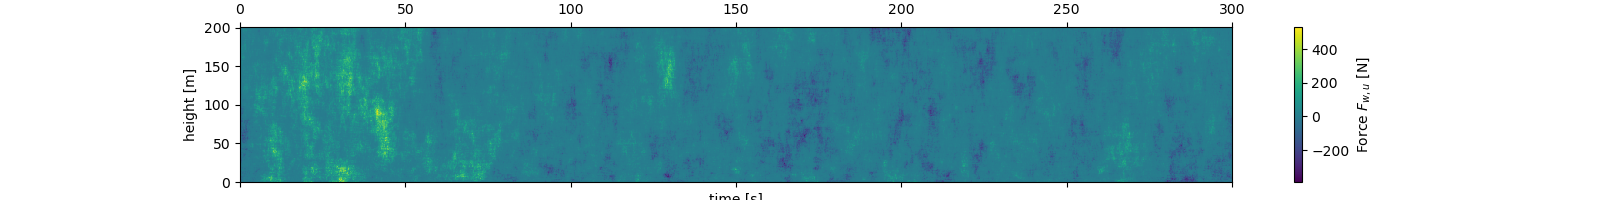

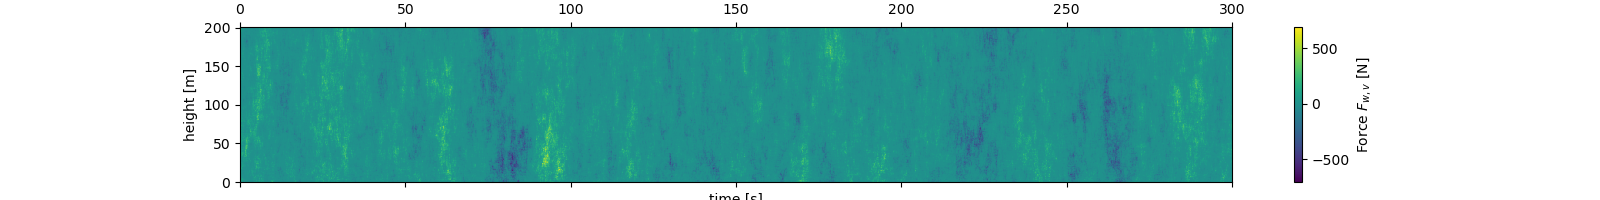

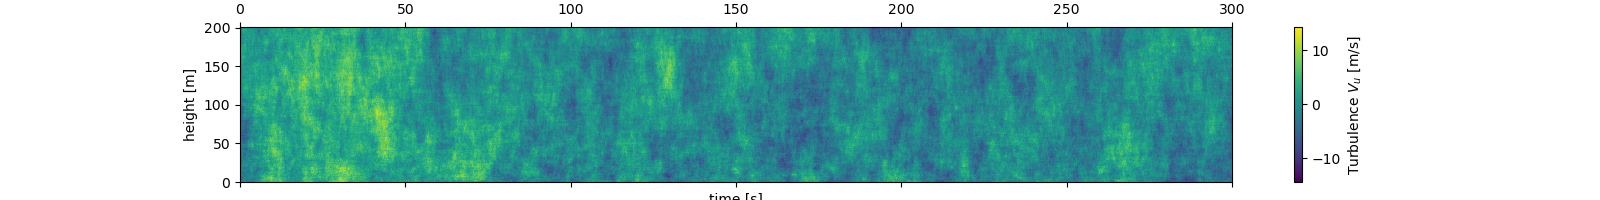

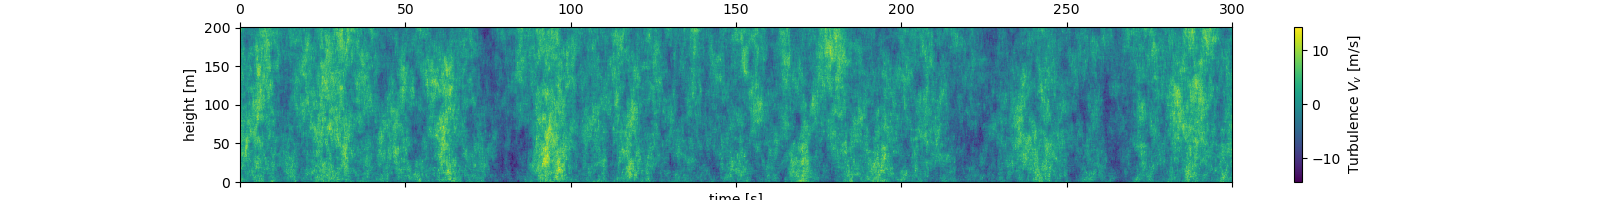

In [53]:
# plt.close('all')
plot_windfield(u_time.T, v_time.T, Fu_time.T, duration=duration)
plot_windfield(F_vj=Fv_time.T, duration=duration)

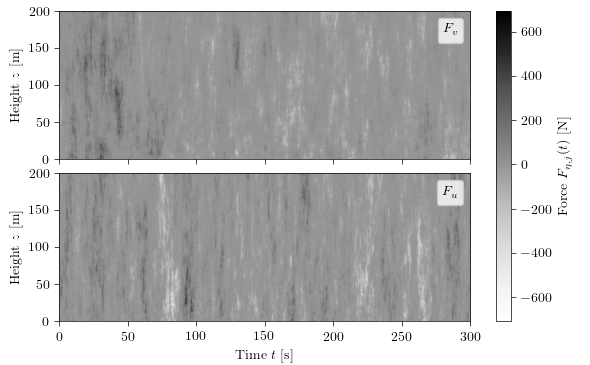

In [75]:
matplotlib.rc('text.latex', preamble=r"\usepackage{siunitx}\usepackage{xfrac}")
plt.close('all')
from helpers import get_pcd
with matplotlib.rc_context(get_pcd('print')):  
    
    Fmin = min([Fu_time.min(), Fv_time.min()])
    Fmax = max([Fu_time.max(), Fv_time.max()])
    fig, axes = plt.subplots(2,1, sharex=True, sharey=True)
    (ax1, ax2) = axes
    im1 = ax1.imshow(Fu_time.T, origin='lower', aspect='auto', extent=(0, duration, 0, struct_parms['L']), 
                     vmin=Fmin, vmax=Fmax, cmap='Greys')
    im2 = ax2.imshow(Fv_time.T, origin='lower', aspect='auto', extent=(0, duration, 0, struct_parms['L']), 
                     vmin=Fmin, vmax=Fmax, cmap='Greys')
    ax2.set_xlabel('Time $t$ [\si{\second}]')
    ax1.set_ylabel('Height $z$ [\si{\metre}]')
    ax2.set_ylabel('Height $z$ [\si{\metre}]')
    # cbar = plt.colorbar()
    # cbar.set_label('Force $F_{u,j}(t)$ [\si{\\newton}]')
    fig.subplots_adjust(top=0.97, bottom=0.12, left=0.1, right=0.97, hspace=0.1)
    fig.colorbar(im2, ax=axes).set_label('Force $F_{\eta,j}(t)$ [\si{\\newton}]')
    axes[1].legend(title='$F_u$')
    axes[0].legend(title='$F_v$')
    
    fig.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/signals_systems/example_windfield_windspeed.png')
    fig.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/signals_systems/example_windfield_windspeed.pdf')
    plt.show()

In [8]:
# np.savez('/home/sima9999/scratch/work/modal_uq/uq_oma_a/samples/8a2a343d/e3f6077f/excitation.npz',
#          Fu_time=Fu_time, Fv_time=Fv_time)

## Transient solution

In [57]:
%%time
# add zero channels for guy support node and tmd node
zeros = np.zeros((N_m, 1))
t, [d_time, v_time, a_time] = mech.transient(fy=np.hstack((Fu_time, zeros, zeros)), 
                                             fz=np.hstack((Fv_time, zeros, zeros)), 
                                             deltat=1 / fs_m, timesteps=N_m)
# remove DOF x
d_time = d_time[:,:,1:]
v_time = v_time[:,:,1:]
a_time = a_time[:,:,1:]
# took 2:16+2:41+2:44+1:25

INFO:model.mechanical:Signal parameters for upcoming transient: deltat 0.010000, dt_fact for f_max 0.485944, timesteps 30000, num_cycles for f_min 47
INFO:model.mechanical:10000 of 30000 timesteps in 2m14s (Remaining ~6m43s; Disk free: 251.67 GB)
INFO:model.mechanical:20000 of 30000 timesteps in 2m32s (Remaining ~5m5s; Disk free: 251.67 GB)
INFO:model.mechanical:30000 of 30000 timesteps in 2m37s (Remaining ~2m37s; Disk free: 251.67 GB)
CPU times: user 43.6 s, sys: 4.15 s, total: 47.7 s
Wall time: 7min 36s


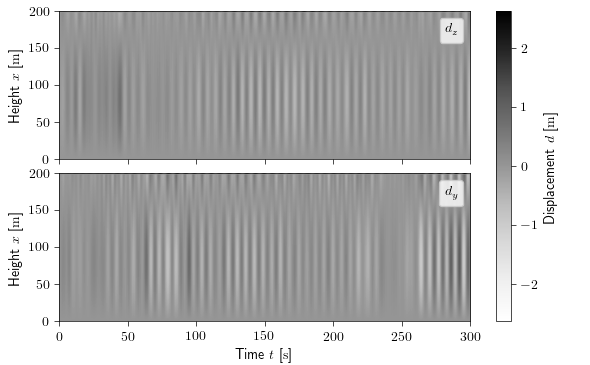

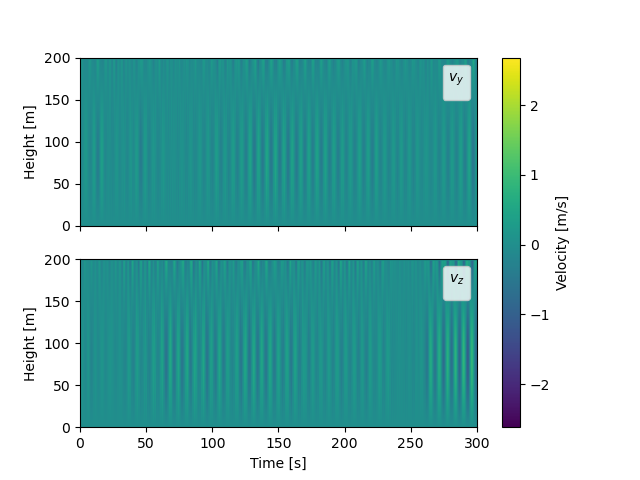

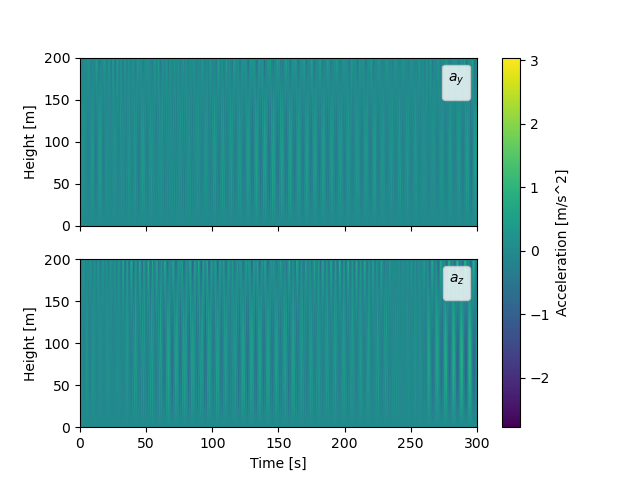

In [87]:

with matplotlib.rc_context(get_pcd('print')):  
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
    vmin, vmax = np.min(d_time), np.max(d_time)
    im1 = axes[0].imshow(d_time[:,:,0].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='y', cmap='Greys')
    im2 = axes[1].imshow(d_time[:,:,1].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='z', cmap='Greys')
    
    fig.subplots_adjust(top=0.97, bottom=0.12, left=0.1, right=0.97, hspace=0.1)
    fig.colorbar(im2, ax=axes).set_label('Displacement $d$ [\si{\metre}]')
    axes[1].set_xlabel('Time $t$ [\si{\second}]')
    axes[1].set_ylabel('Height $x$ [\si{\metre}]')
    axes[1].legend(title='$d_y$')
    axes[0].set_ylabel('Height $x$ [\si{\metre}]')
    axes[0].legend(title='$d_z$')
    fig.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/structural_dynamics/example_windresponse_transient.png')
    fig.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/structural_dynamics/example_windresponse_transient.pdf')

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
vmin, vmax = np.min(v_time), np.max(v_time)
im1 = axes[0].imshow(v_time[:,:,0].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='y')
im2 = axes[1].imshow(v_time[:,:,1].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='z')
fig.colorbar(im2, ax=axes).set_label('Velocity [m/s]')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Height [m]')
axes[1].legend(title='$v_z$')
axes[0].set_ylabel('Height [m]')
axes[0].legend(title='$v_y$')

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
vmin, vmax = np.min(a_time), np.max(a_time)
im1 = axes[0].imshow(a_time[:,:,0].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='y')
im2 = axes[1].imshow(a_time[:,:,1].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='z')
fig.colorbar(im2, ax=axes).set_label('Acceleration [m/s^2]')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Height [m]')
axes[1].legend(title='$a_z$')
axes[0].set_ylabel('Height [m]')
axes[0].legend(title='$a_y$')

## FRF Solution

In [86]:
%%time
mech.omegas = None
time_values, [d_freq_time, v_freq_time, a_freq_time] = mech.transient_ifrf(Fu_time, Fv_time, 
                                                                           mech.nodes_coordinates[0:-2,0],
                                                                            inp_dt = 1/fs_m)
d_freq = mech.d_freq
omegas = mech.omegas

INFO:model.mechanical:FRF computation for non-classical modes with 15001 frequency lines in the frequency range up to 50.0 Hz and 46 modes for 402 input and 406 output nodes.
|████████████████████████████████████████| 46/46 [100%] in 1:52.2 (0.41/s)      
The pre-computed FRF array is of type <class 'numpy.ndarray'>
CPU times: user 28min 12s, sys: 1min 34s, total: 29min 46s
Wall time: 2min 2s


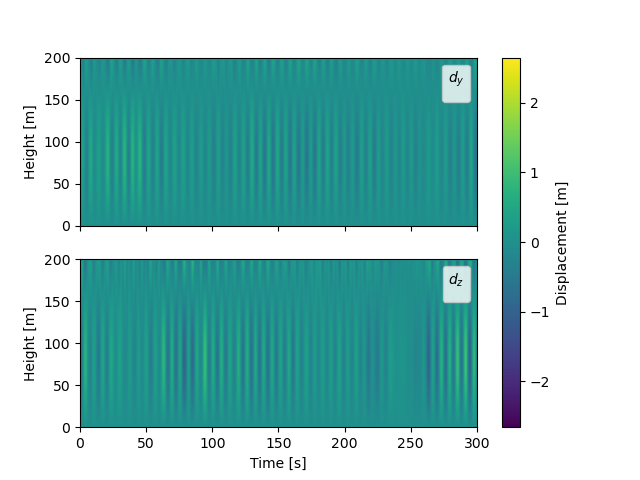

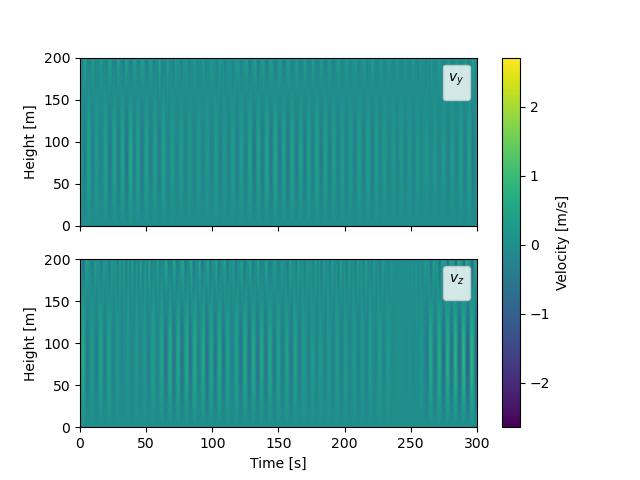

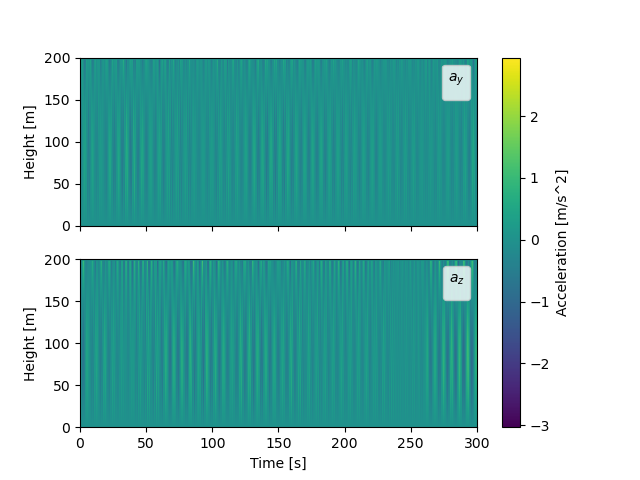

In [61]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
vmin, vmax = np.min(d_freq_time), np.max(d_freq_time)
im1 = axes[0].imshow(d_freq_time[:,:,0].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='y')
im2 = axes[1].imshow(d_freq_time[:,:,1].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='z')
fig.colorbar(im2, ax=axes).set_label('Displacement [m]')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Height [m]')
axes[1].legend(title='$d_z$')
axes[0].set_ylabel('Height [m]')
axes[0].legend(title='$d_y$')

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
vmin, vmax = np.min(v_freq_time), np.max(v_freq_time)
im1 = axes[0].imshow(v_freq_time[:,:,0].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='y')
im2 = axes[1].imshow(v_freq_time[:,:,1].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='z')
fig.colorbar(im2, ax=axes).set_label('Velocity [m/s]')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Height [m]')
axes[1].legend(title='$v_z$')
axes[0].set_ylabel('Height [m]')
axes[0].legend(title='$v_y$')

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
vmin, vmax = np.min(a_freq_time), np.max(a_freq_time)
im1 = axes[0].imshow(a_freq_time[:,:,0].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='y')
im2 = axes[1].imshow(a_freq_time[:,:,1].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='z')
fig.colorbar(im2, ax=axes).set_label('Acceleration [m/s^2]')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Height [m]')
axes[1].legend(title='$a_z$')
axes[0].set_ylabel('Height [m]')
axes[0].legend(title='$a_y$')

## Verification FRF & Transient

### Animation

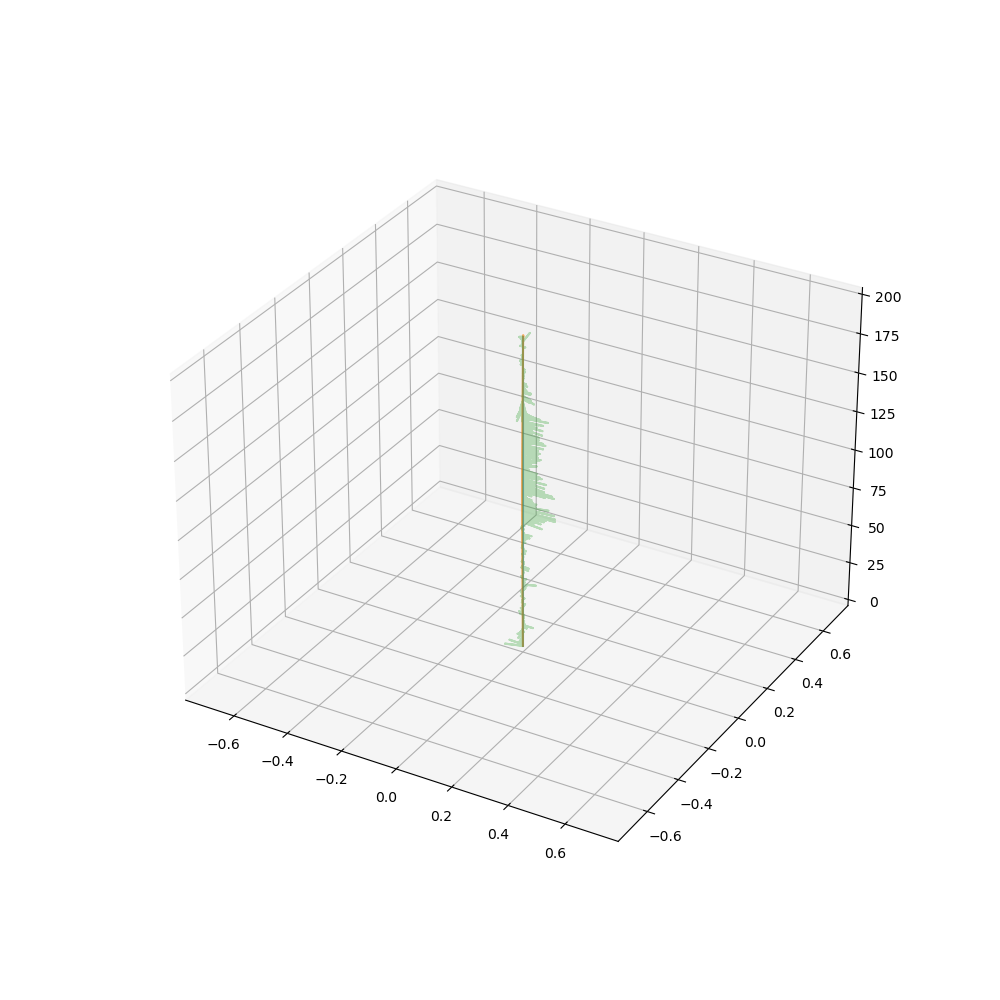

In [48]:
N_frames=25#N_m

# compare time histories by animating response side-by-side
from matplotlib.animation import FuncAnimation
plt.close('all')

ind = np.ones(len(x_grid) + 2, dtype=bool)
ind[-2] = False

if True: # transient results
    uy1 = d_time[:,ind,0]
    uz1 = d_time[:,ind,1]
else:
    uy1,uz1=None,None
if True: # FRF results
    uy2 = d_freq_time[:,ind,0]
    uz2 = d_freq_time[:,ind,1]
else:
    uy2,uz2=None,None    

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
z = x_grid
zero = np.zeros_like(z)

if uy1 is not None:
    lines_response1 = ax.plot(uy1[0, :], uz1[0, :], mech.nodes_coordinates[ind,1], alpha=0.6)[0]
    lim = np.max([-np.min(uy1), np.max(uy1), -np.min(uz1), np.max(uz1)])*20
else:
    lines_response1 = None

if uy2 is not None:
    lines_response2 = ax.plot(uy2[0, :], uz2[0, :], mech.nodes_coordinates[ind,1], alpha=0.6)[0]
    lim = np.max([-np.min(uy2), np.max(uy2), -np.min(uz2), np.max(uz2)])*20
else:
    lines_response2 = None
    
ax.set_xlim((-lim, lim))
ax.set_ylim((-lim, lim))


Flim = np.max([-np.min(Fu_time), np.max(Fu_time), -np.min(Fv_time), np.max(Fv_time)])

F_uj_inter = np.empty((3*len(x_grid),), dtype=Fu_time.dtype)
F_uj_inter[0::3] = zero
F_uj_inter[1::3] = Fu_time[0, :]*lim/Flim
F_uj_inter[2::3] = zero

F_vj_inter = np.empty((3*len(x_grid),), dtype=Fv_time.dtype)
F_vj_inter[0::3] = zero
F_vj_inter[1::3] = Fv_time[0, :]*lim/Flim
F_vj_inter[2::3] = zero

x_grid_inter = np.empty((3*len(x_grid),), dtype=x_grid.dtype)
x_grid_inter[0::3] = x_grid
x_grid_inter[1::3] = x_grid
x_grid_inter[2::3] = x_grid

lines_force = ax.plot(F_uj_inter, F_vj_inter, x_grid_inter, alpha=0.3)[0]

# lines_force+lines_response

def update(n):
    F_uj_inter[1::3] = Fu_time[n, :]*lim/Flim
    F_vj_inter[1::3] = Fv_time[n, :]*lim/Flim
    lines_force.set_data(F_uj_inter, F_vj_inter)
    lines_force.set_3d_properties(x_grid_inter)
    if uy1 is not None:
        lines_response1.set_data(uy1[n, :], uz1[n, :])
        lines_response1.set_3d_properties(mech.nodes_coordinates[ind,1])
    if uy2 is not None:
        lines_response2.set_data(uy2[n, :], uz2[n, :])
        lines_response2.set_3d_properties(mech.nodes_coordinates[ind,1])
        
    return lines_force

ani = FuncAnimation(fig, update, frames=N_m, blit=True, interval=33, repeat=False)
plt.show()   

In [49]:
ani.pause()
ani._stop()
plt.close('all')
del ani

### Spectra

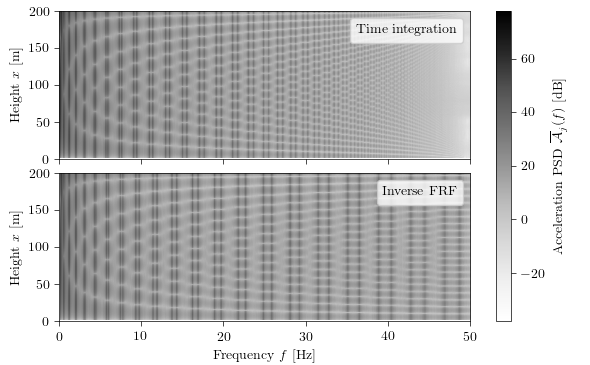

Text(0, 0.5, 'Height [m]')

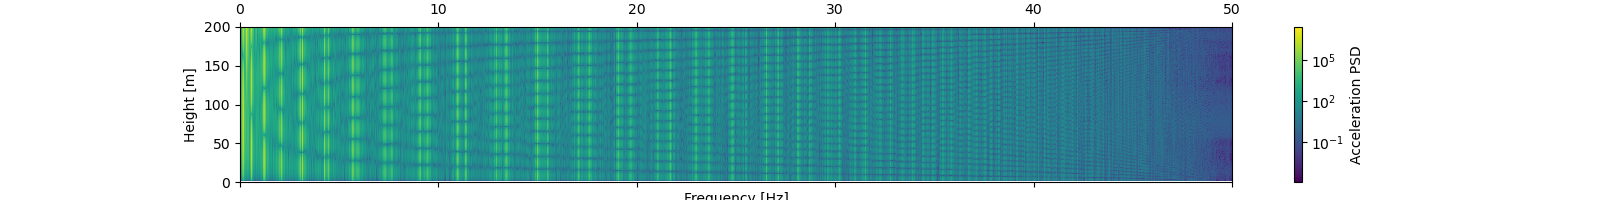

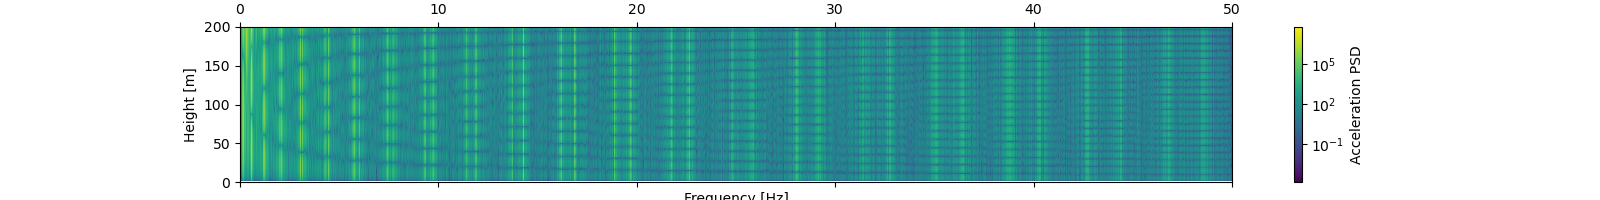

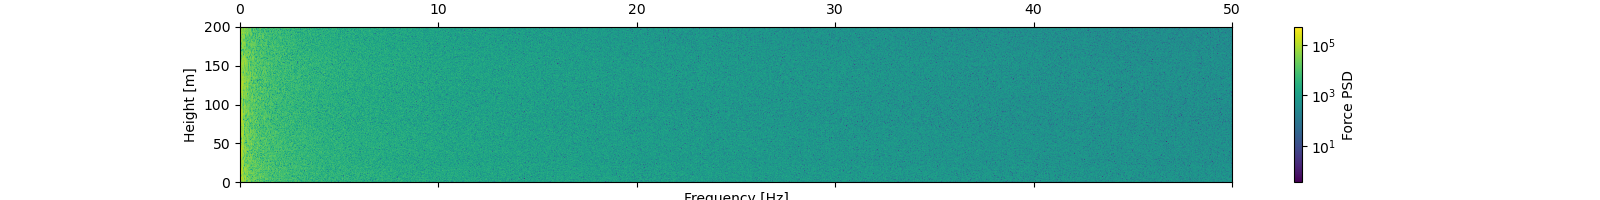

In [95]:
a_time_spec = np.fft.rfft(a_time, axis=0)**2
a_time_spec_polar_mag = np.abs(a_time_spec[:,:num_nodes,0].T) + np.abs(a_time_spec[:,:num_nodes,1].T)
a_freq_spec = (d_freq * -1 * omegas[:, np.newaxis, np.newaxis]**2)**2
a_freq_spec_polar_mag = np.abs(a_freq_spec[:,:num_nodes, 0].T) + np.abs(a_freq_spec[:,:num_nodes, 1].T)

with matplotlib.rc_context(get_pcd('print')):  
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
    vmin, vmax = np.min(d_time), np.max(d_time)
    im1 = axes[0].imshow(10*np.log10(a_time_spec_polar_mag), origin='lower', aspect='auto', extent=(0, fs_m/2, x_grid[0], x_grid[-1]), cmap='Greys')
    # im1 = axes[0].imshow(a_time_spec_polar_mag, origin='lower', aspect='auto', extent=(0, fs_m/2, x_grid[0], x_grid[-1]),norm='log', cmap='Greys')
    # im2 = axes[1].imshow(a_freq_spec_polar_mag, origin='lower', aspect='auto', extent=(0, fs_m/2, x_grid[0], x_grid[-1]),norm='log', cmap='Greys')
    im2 = axes[1].imshow(10*np.log10(a_freq_spec_polar_mag), origin='lower', aspect='auto', extent=(0, fs_m/2, x_grid[0], x_grid[-1]),cmap='Greys')

    fig.subplots_adjust(top=0.97, bottom=0.12, left=0.1, right=0.97, hspace=0.1)
    fig.colorbar(im2, ax=axes).set_label('Acceleration PSD $\overline{\mathcal{A}}_j(f)$ [\si{\decibel}]')
    axes[1].set_xlabel('Frequency $f$ [\si{\hertz}]')
    axes[1].set_ylabel('Height $x$ [\si{\metre}]')
    axes[0].legend(title='Time integration')
    axes[0].set_ylabel('Height $x$ [\si{\metre}]')
    axes[1].legend(title='Inverse FRF')
    fig.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/structural_dynamics/example_windresponse_spectra.png')
    fig.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/structural_dynamics/example_windresponse_spectra.pdf')
    plt.show()

plt.matshow(a_time_spec_polar_mag, origin='lower', aspect='auto', extent=(0, fs_m/2, x_grid[0], x_grid[-1]),norm='log')
plt.colorbar().set_label('Acceleration PSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Height [m]')

plt.matshow(a_freq_spec_polar_mag , origin='lower', aspect='auto', extent=(0, fs_m/2, x_grid[0], x_grid[-1]),norm='log')
plt.colorbar().set_label('Acceleration PSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Height [m]')

plt.matshow(np.abs(Fu_freq).T , origin='lower', aspect='auto', extent=(0, fs_m/2, x_grid[0], x_grid[-1]),norm='log')
plt.colorbar().set_label('Force PSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Height [m]')

Text(0, 0.5, 'Acceleration PSD [ms^-2Hz^-1]')

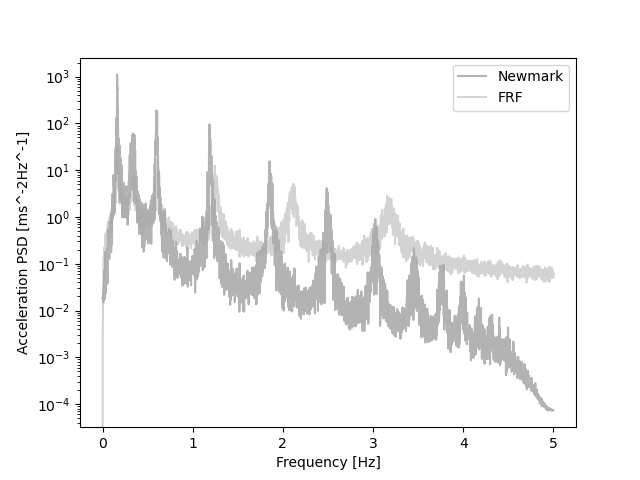

In [234]:
plt.figure()
plt.plot(f_w.squeeze(), np.mean(a_time_spec_polar_mag, axis=0), alpha=0.5, label='Newmark', color='dimgrey')
plt.plot(f_w.squeeze(), np.mean(a_freq_spec_polar_mag, axis=0), alpha=0.5, label='FRF', color='darkgrey')
# for i in range(2):
# plt.plot(f_w.squeeze(), a_spec_svd[0,:], alpha=0.5)
# plt.plot(f_w.squeeze(), outfrff_svd[0,:], alpha=0.5)
plt.yscale('log')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Acceleration PSD [ms^-2Hz^-1]')

## Validation

In [3]:
import xarray as xr

stats_wind = xr.load_dataset('/usr/scratch4/sima9999/work/stats_wind.nc')
stats_wind = stats_wind.where(stats_wind['error']==0)
stats_wind = stats_wind.sel(channels='Wg')
stats_wind = stats_wind.where(~np.isnan(stats_wind['mean']))
stats_wind = stats_wind.where(stats_wind['mean']<30)
stats_wind = stats_wind.where(np.log(stats_wind['mean'])>=-2)
stats_wind = stats_wind.where(np.sqrt(stats_wind['var'])/stats_wind['mean']<=0.2)
stats_wind = stats_wind.where(np.sqrt(stats_wind['var'])/stats_wind['mean']>=0.1)

stats_accel = xr.load_dataset('/usr/scratch4/sima9999/work/stats_accel.nc')
stats_accel = stats_accel.sel(channels=['Accel_01', 'Accel_02'])
stats_accel = stats_accel.where(stats_accel['rms']<0.2)

stats_wind, stats_accel = xr.align(stats_wind, stats_accel, exclude=['channels','modes'])

In [ ]:
def get_rms(v_b):
    v_m, sigma_v, L = basic_wind_parameters(x_grid, v_b, z_min, alpha, vm_fact, vm_min, Iv_fact, Iv_min, eps)
    
    c_uj, c_vj = spectral_wind_field(x_grid, f_w, 
                                     L, v_m, sigma_v, C_uz=10, C_vz=7, C_wz=4, 
                                     seed=None)
    
    u_j, v_j = temporal_wind_field(c_uj, c_vj, N_m)
    
    F_uj, F_vj = force_wind_field(u_j, v_j, delta_x=x_grid[1]-x_grid[0], 
                                  b=1.9, cscd=1.0, cf=2.86519, rho=1.25)
    
    fF_uj = np.fft.rfft(F_uj)
    fF_vj = np.fft.rfft(F_vj)
    
    fF = np.vstack([fF_uj, fF_vj]).T # n_lines, n_inp_nodes*n_inp_dofs
    outfrff = np.empty((N_m // 2 + 1, 2 * (num_nodes + 2)), dtype=complex)

    for i in range(N_m // 2 + 1):
        np.dot(fF[i,:], frf[i,:,:], out=outfrff[i,:])

    # dfrf = np.fft.irfft(outfrff, axis=0).T
    # vfrf = np.fft.irfft(outfrff* 1j*omegas[:, np.newaxis], axis=0).T
    afrf = np.fft.irfft(outfrff*-1j*omegas[:, np.newaxis]**2, axis=0).T

    # rms = np.sqrt(np.mean(afrf**2, axis=1))
    # acceleration level regardless of direction, exclude guy support node and tmd node
    rms = np.sqrt(np.mean(afrf[:(num_nodes),:]**2 + afrf[(num_nodes + 2):-2,:]**2, axis=1))
    return rms

v_b = scipy.stats.weibull_min.rvs(2.28,scale=5.64, size=1000)
rms = np.empty((num_nodes, v_b.shape[0]))
for i in range(v_b.shape[0]):
    rms[:,i] = get_rms(v_b[i])
# np.savez('/usr/scratch4/sima9999/work/modal_uq/v_vs_rms.npz', v_b=v_b, rms=rms)

Text(0, 0.5, 'Acceleration RMS [ms^-2]')

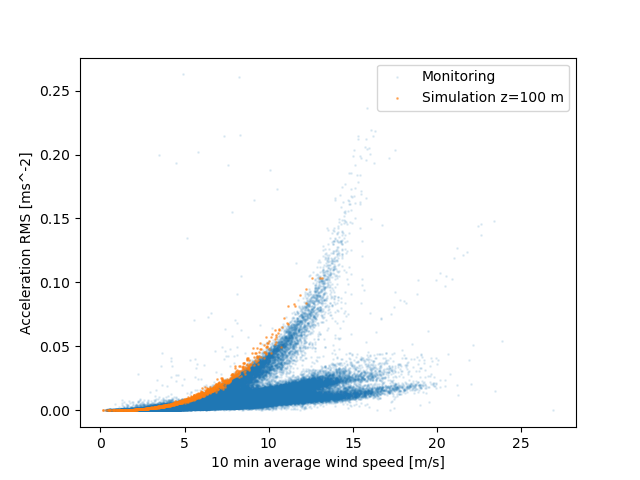

In [4]:
arr = np.load('/usr/scratch4/sima9999/work/modal_uq/v_vs_rms.npz')
v_b = arr['v_b']
rms = arr['rms']
plt.figure()
plt.scatter(stats_wind['mean'], np.sqrt(stats_accel.sel(channels='Accel_02')['rms']**2 + stats_accel.sel(channels='Accel_01')['rms']**2),s=1, alpha=0.1, label='Monitoring')
plt.scatter(v_b, rms[100,:],  s=1, alpha=0.5, label='Simulation z=100 m')
plt.legend()
plt.xlabel('10 min average wind speed [m/s]')
plt.ylabel('Acceleration RMS [ms^-2]')

Continue

 Section 2.2.2
 
 Chapter 1 (Truss description, Wind-Force parameters, example wind response, comparison experimental: wind distribution, rms vs vb)
 
- write down - model description w/ theory, thesis/paperlike:
    - structural model: 
        - guyed mast: simplification, linearization, cross-section w/ rotation, TMD design, further parameters
        - modal solution: method and example, 
    - turbulent wind generation:
        - basic wind parameters (EN 1991),
        - Spectral description, decomposition and time history generation w/ example (run-times), 
        - Force calculation (EN 1991) w/ example
    - model response:
        - transient parameters and example
        - frf parameters and example
        - comparison and run-times
        
Build measurement chain
model uncertainties